<a href="https://colab.research.google.com/github/JuanFdoGf/PracticasDS/blob/main/Perceptr%C3%B3nMulticapa_Identificaci%C3%B3nAudio_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kongaevans/speaker-recognition-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/kongaevans/speaker-recognition-dataset/versions/1


In [2]:
# Definimos un conjunto de constantes con las rutas de las carpetas que contienen los audios de cada persona
import os

DATASET_ROOT = '/root/.cache/kagglehub/datasets/kongaevans/speaker-recognition-dataset/versions/1/16000_pcm_speeches'
BENJAMIN_DATA = os.path.join(DATASET_ROOT, 'Benjamin_Netanyau')
JENS_DATA = os.path.join(DATASET_ROOT, 'Jens_Stoltenberg')
JULIA_DATA = os.path.join(DATASET_ROOT, 'Julia_Gillard')
MARGARET_DATA = os.path.join(DATASET_ROOT, 'Magaret_Tarcher')
NELSON_DATA = os.path.join(DATASET_ROOT, 'Nelson_Mandela')

In [3]:
# Definimos una función para parsear nuestro conjunto de datos
import librosa
import numpy as np

def parse_dataset(dataset_paths):
    X = []
    y = []
    for index, dataset in enumerate(dataset_paths):
        print('[+] Parsing {} data...'.format(dataset))
        for fname in os.listdir(dataset):
            wav, sr = librosa.load(os.path.join(dataset, fname), sr=None)
            D = librosa.amplitude_to_db(np.abs(librosa.stft(wav)), ref=np.max)
            X.append(D)
            y.append(index)
    return (X, y)

In [4]:
X, y = parse_dataset([BENJAMIN_DATA, JENS_DATA, JULIA_DATA, MARGARET_DATA, NELSON_DATA])

[+] Parsing /root/.cache/kagglehub/datasets/kongaevans/speaker-recognition-dataset/versions/1/16000_pcm_speeches/Benjamin_Netanyau data...
[+] Parsing /root/.cache/kagglehub/datasets/kongaevans/speaker-recognition-dataset/versions/1/16000_pcm_speeches/Jens_Stoltenberg data...
[+] Parsing /root/.cache/kagglehub/datasets/kongaevans/speaker-recognition-dataset/versions/1/16000_pcm_speeches/Julia_Gillard data...
[+] Parsing /root/.cache/kagglehub/datasets/kongaevans/speaker-recognition-dataset/versions/1/16000_pcm_speeches/Magaret_Tarcher data...
[+] Parsing /root/.cache/kagglehub/datasets/kongaevans/speaker-recognition-dataset/versions/1/16000_pcm_speeches/Nelson_Mandela data...


## División del conjunto de datos

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [6]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [7]:
print('Longitud subconjunto de entrenamiento: ', len(X_train))
print('Longitud subconjunto de validación: ', len(X_val))
print('Longitud subconjunto de pruebas: ', len(X_test))

Longitud subconjunto de entrenamiento:  6750
Longitud subconjunto de validación:  376
Longitud subconjunto de pruebas:  375


##3. Construcción del modelo

In [8]:
from tensorflow.keras.utils import to_categorical

def prep_dataset(X, y, shape):
    X_prep = np.array(X).reshape((len(X), shape))
    X_prep = X_prep.astype('float32') / 255
    y_prep = to_categorical(np.array(y))
    return (X_prep, y_prep)

In [9]:
X_train_prep, y_train_prep = prep_dataset(X_train, y_train, 1025*32)
X_val_prep, y_val_prep = prep_dataset(X_val, y_val, 1025*32)
X_test_prep, y_test_prep = prep_dataset(X_test, y_test, 1025*32)

In [10]:
X_train_prep

array([[-0.12571123, -0.13585922, -0.16132393, ..., -0.3137255 ,
        -0.25836417, -0.21693064],
       [-0.13111399, -0.15394041, -0.15587866, ..., -0.3137255 ,
        -0.3137255 , -0.31114417],
       [-0.13622974, -0.1577261 , -0.25646946, ..., -0.3137255 ,
        -0.22508088, -0.18632606],
       ...,
       [-0.3137255 , -0.3137255 , -0.3137255 , ..., -0.3137255 ,
        -0.30247504, -0.26258004],
       [-0.15690815, -0.16646668, -0.17308708, ..., -0.3137255 ,
        -0.3021076 , -0.2648278 ],
       [-0.24957637, -0.26426044, -0.2933899 , ..., -0.3137255 ,
        -0.2582578 , -0.21914698]], dtype=float32)

In [11]:
y_train_prep

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [12]:
# Entrenamos un perceptrón multicapa
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')
clf.fit(X_train_prep, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(10,), solver='sgd')

In [13]:
# Realizamos la predicción con el conjunto de datos de validación
y_pred = clf.predict(X_val_prep)

In [14]:
# Mostramos el accuracy resultante de la clasificación
from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred)

0.9574468085106383

In [15]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Input

In [16]:
network = models.Sequential([
    Input(shape=(1025*32,)),
    layers.Dense(300, activation='relu'),
    layers.Dense(200, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(5, activation='softmax')
])

In [17]:
network.compile(loss='categorical_crossentropy',
                optimizer='sgd',
                metrics=['accuracy', 'Precision'])

In [18]:
history = network.fit(X_train_prep,
                      y_train_prep,
                      epochs=30,
                      validation_data=(X_val_prep, y_val_prep))

Epoch 1/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - Precision: 0.4781 - accuracy: 0.3404 - loss: 1.4789 - val_Precision: 0.7912 - val_accuracy: 0.5160 - val_loss: 1.1256
Epoch 2/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - Precision: 0.7086 - accuracy: 0.5243 - loss: 1.1242 - val_Precision: 0.6859 - val_accuracy: 0.5612 - val_loss: 1.0306
Epoch 3/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - Precision: 0.7690 - accuracy: 0.6366 - loss: 0.8802 - val_Precision: 0.9060 - val_accuracy: 0.7846 - val_loss: 0.6125
Epoch 4/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - Precision: 0.7798 - accuracy: 0.7027 - loss: 0.7677 - val_Precision: 0.7857 - val_accuracy: 0.7367 - val_loss: 0.6590
Epoch 5/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - Precision: 0.8080 - accuracy: 0.7452 - loss: 0.6779 - val_Precision: 0.7812 - val_accuracy: 0.7500 - val_loss: 0.7812
Epoch 6/30
211/211 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - Precision: 0.8362 - accuracy: 0.7831 - loss: 0.5734 - val_Precision: 0.955

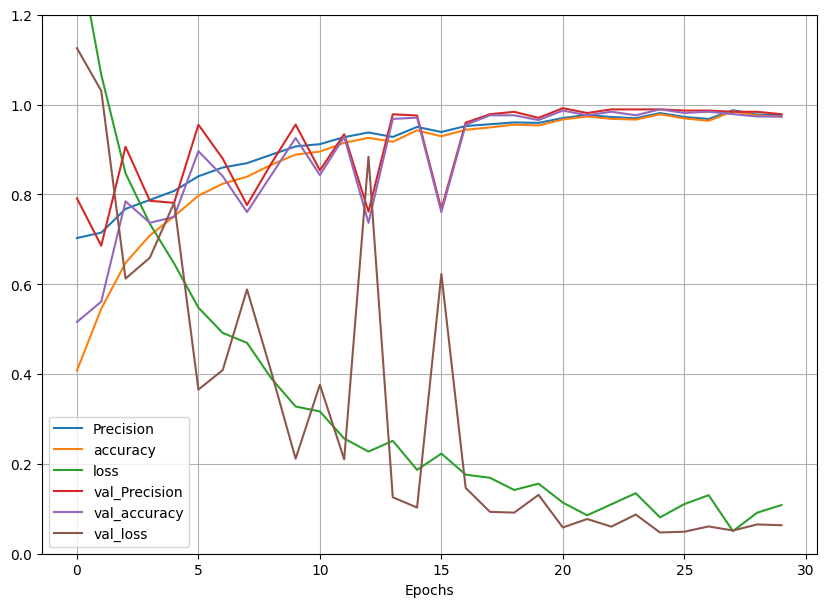

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.xlabel('Epochs')
plt.show()

In [20]:
# Realizamos la predicción para el subconjunto de pruebas
test_loss, test_acc, test_prec = network.evaluate(X_test_prep, y_test_prep)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - Precision: 0.9782 - accuracy: 0.9783 - loss: 0.0716


In [21]:
print('test_acc:', test_acc)
print('test_prec:', test_prec)

test_acc: 0.9786666631698608
test_prec: 0.9786096215248108
